In [1]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline 
from sklearn.metrics import cohen_kappa_score, precision_recall_fscore_support, roc_auc_score, roc_curve, f1_score, confusion_matrix
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)

In [2]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from __future__ import division
import os

from matplotlib import pyplot as plt
%matplotlib inline
import missingno as msno

import category_encoders as ce
from sklearn import preprocessing

#library to get text similarity
import jellyfish

import pycountry
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2
    
import mpu    

import time
from datetime import date

pd.options.display.float_format = "{:.2f}".format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
np.set_printoptions(threshold=np.nan)  

# Read data

In [3]:
df=pd.read_csv('/home/gjain/df_cat_enc_part1.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
#target value counts

0    2221797
1    2197   
Name: target, dtype: int64

In [4]:
#target, timestamp, order_number, pay_id not included below
#72 cols
all_cols=['affiliate','channelcode',
       'local_trans_amt', 'trans_currency', 'nonmor', 'payment_method', 'eci',
       'card_cvvmatch', 'card_avsmatch', 'customer_title', 'website_language',
       'brand_continent', 'HasTicketInsurance', 'HasInsurance', 'HasBaggage',
       'HasBaggage_Sale', 'HasAirhelpPlus', 'UsedVoucher', 'HasSP', 'gender',
       'BookerCity', 'BookerCountry_Name', 'TotalAmountEUR', 'airline',
       'Consolidator', 'OriginAirportCode', 'OriginCityName',
       'OriginCountryName', 'OriginWorldPartName', 'OriginRegion',
       'OriginSubRegion', 'DestinationAirportCode', 'DestinationCityName',
       'DestinationCountryName', 'DestinationWorldPartName',
       'DestinationRegion', 'DestinationSubRegion', 'Supplier',
       'DomesticOrInternational', 'Haul', 'OneWayOrReturn', 'IsCombinedOneWay',
       'IsITFare', 'TotalNumberOfPassengers', 'TotalNumberOfAdults',
       'TotalNumberOfChildren', 'TotalNumberOfInfants', 'COW_NumberOfSegments',
       'COW_NumberOfInboundSegments', 'COW_NumberOfOutboundSegments',
       'NumberOfTickets', 'FareBaseAmount', 'HasSplitPnr', 'DeviceType',
       'OrderDateBrandTime_Month', 'IsLowCost', 'email_user_id_len',
       'email_domain', 'dob_month', 'bookerIsTravelAgency',
       'successful_attempt_no', 'country_ip_flight_MatchScore',
       'flight_distance', 'days_to_departure', 'vacation_length',
       'cities_in_itinerary', 'cabin_class', 'name_len', 'weekend_booking',
       'booking_daytime', 'bookerAgeBracket', 'email_sanity_score']

loo_cols=['affiliate','channelcode','trans_currency','payment_method','eci','website_language','BookerCity',
          'BookerCountry_Name','airline',
          'Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName',
          'DestinationWorldPartName','DestinationSubRegion','email_domain']   

all_cat_cols=['affiliate','channelcode','trans_currency','nonmor','payment_method','eci','card_cvvmatch','card_avsmatch','customer_title','website_language',
          'brand_continent','HasTicketInsurance','HasInsurance','HasBaggage','HasBaggage_Sale','HasAirhelpPlus','UsedVoucher','HasSP','gender',
          'BookerCity','BookerCountry_Name','airline','Consolidator','OriginAirportCode','OriginCityName','OriginCountryName','OriginWorldPartName','OriginRegion',
          'OriginSubRegion','DestinationAirportCode','DestinationCityName','DestinationCountryName','DestinationWorldPartName','DestinationRegion','DestinationSubRegion',
          'Supplier','DomesticOrInternational','Haul','OneWayOrReturn','IsCombinedOneWay','IsITFare',
          'HasSplitPnr','DeviceType','IsLowCost','email_domain','cabin_class','bookerIsTravelAgency','weekend_booking','OrderDateBrandTime_Month','dob_month','booking_daytime',
         'bookerAgeBracket']

#Get location of loo_cols, our categorical columns, in df[all_cols], to feed in Pool
df2=df[all_cols]
categorical_features_pos=[df2.columns.get_loc(c) for c in loo_cols]
categorical_features_pos

[0, 1, 3, 5, 6, 10, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 57]

### Create Pool object for training data. Data can only be passed to catboost in this way

In [22]:
# #Reading data
# train_data = Pool(
#     data=df2.values,
#     label=df.target.values,
#     cat_features=categorical_features_pos,
#     has_header=True,
#     thread_count=-1
# )

# print(train_data.shape)
# print(train_data.is_empty_)

# #Since cat_features is already defined here, it will not be used in the fit method

In [ ]:
### Train-test split
# from sklearn.model_selection import train_test_split

# #Split data_for_sample into Train(70%) and Test(30%) 
# X_train, X_test, Y_train, Y_test = train_test_split(features, target, train_size=0.7,random_state = 12)

# print(features.shape)
# print('X_train:',X_train.shape)
# print('X_test:',X_test.shape)
# print('Y_train:',Y_train.shape)
# print('Y_test:',Y_test.shape)

# Hyperparameter tuning using GridSearchCV

### Class weights for handling class imbalance

In [15]:
from sklearn.utils import class_weight

# class_weights={0: 1., 1: 50.}
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df.target),
                                                 df.target)
class_weights

array([  5.00494420e-01,   5.06143377e+02])

In [13]:
#rsm: Random subspace method. The percentage of features to use at each split selection, when features are selected over again at random.
seed=26
train_dir='/home/gjain/'

start_time = time.time()
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````

#Define estimator
cb_clf=CatBoostClassifier(cat_features=categorical_features_pos, 
#                           class_weights=class_weights,
                          loss_function='Logloss', nan_mode='Min', random_seed=seed, 
                       one_hot_max_size=3, train_dir=train_dir, 
                       custom_loss=['AUC', 'F1','Kappa'], 
                      od_type='Iter')

#Set up pipeline
steps = [("model", cb_clf)]
pipe = Pipeline(steps)

tune_params =   {'model__n_estimators':[650],
                 'model__learning_rate':[0.1],
                 'model__depth':[10],
                 'model__l2_leaf_reg':[5],
                 'model__size_reg':[0.5],
                 'model__rsm':[0.6], 
                 'model__class_weights':[[0.5,400]]
                 }

fit_parameters={'model__plot':True,
                'model__early_stopping_rounds':5,
                'model__metric_period': 100}
                #metric period is to control verbosity of catboost

model=RandomizedSearchCV(pipe, param_distributions=tune_params,scoring='f1', 
                         n_iter=10, 
#                          n_jobs=-1,
                         refit=True, cv=5, verbose=10,return_train_score=True)
#n_iter in randomisedsearchcv is number of param combos to try

# model=GridSearchCV(pipe, param_grid=tune_params,scoring='f1', refit=True, 
#                       cv=5, verbose=0,return_train_score=True)

model=model.fit(df2,df.target,**fit_parameters)

best_params=model.best_params_ 

# best_est=model.best_estimator_

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#`````````````````````````````````````````````````````````````````````````````````````````````````
print ('Best params for the model are:')
print (model.best_params_)
print('Best score:')
print(model.best_score_)
print ('-------------------------------')

pd.DataFrame(model.cv_results_).to_csv('cv_results.csv')

end_time = time.time()
time_taken = end_time - start_time # time_taken is in seconds
minutes, seconds = divmod(time_taken, 60)

/root/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5 


0:	learn: 0.5442317	total: 4.72s	remaining: 51m 3s
100:	learn: 0.0192407	total: 6m 32s	remaining: 35m 32s
200:	learn: 0.0063703	total: 13m 45s	remaining: 30m 45s
300:	learn: 0.0049646	total: 21m 46s	remaining: 25m 14s
400:	learn: 0.0041242	total: 29m 50s	remaining: 18m 31s
500:	learn: 0.0034901	total: 38m 3s	remaining: 11m 19s
600:	learn: 0.0030862	total: 46m 34s	remaining: 3m 47s
649:	learn: 0.0028411	total: 53m 48s	remaining: 0us
[CV]  model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5, score=0.5640599001663893, total=54.9min
[CV] model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 55.7min remaining:    0.0s


0:	learn: 0.5588634	total: 4.18s	remaining: 45m 14s
100:	learn: 0.0165201	total: 6m 45s	remaining: 36m 42s
200:	learn: 0.0064811	total: 13m 50s	remaining: 30m 55s
300:	learn: 0.0049777	total: 21m 44s	remaining: 25m 12s
400:	learn: 0.0042298	total: 29m 43s	remaining: 18m 27s
500:	learn: 0.0035185	total: 37m 36s	remaining: 11m 11s
600:	learn: 0.0031033	total: 45m 24s	remaining: 3m 42s
649:	learn: 0.0028896	total: 49m 19s	remaining: 0us
[CV]  model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5, score=0.5114560236511456, total=50.4min
[CV] model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 106.8min remaining:    0.0s


0:	learn: 0.5604398	total: 3.98s	remaining: 43m 4s
100:	learn: 0.0157672	total: 6m 30s	remaining: 35m 22s
200:	learn: 0.0056889	total: 13m 42s	remaining: 30m 37s
300:	learn: 0.0043607	total: 21m 10s	remaining: 24m 32s
400:	learn: 0.0036269	total: 28m 53s	remaining: 17m 56s
500:	learn: 0.0031558	total: 36m 41s	remaining: 10m 54s
600:	learn: 0.0026300	total: 44m 25s	remaining: 3m 37s
649:	learn: 0.0024624	total: 48m 16s	remaining: 0us
[CV]  model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5, score=0.5221843003412968, total=49.4min
[CV] model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 157.0min remaining:    0.0s


0:	learn: 0.5855967	total: 1.86s	remaining: 20m 7s
100:	learn: 0.0141921	total: 6m 53s	remaining: 37m 28s
200:	learn: 0.0057529	total: 14m	remaining: 31m 17s
300:	learn: 0.0043799	total: 21m 57s	remaining: 25m 27s
400:	learn: 0.0038802	total: 31m 22s	remaining: 19m 28s
500:	learn: 0.0033300	total: 45m 44s	remaining: 13m 36s
600:	learn: 0.0029422	total: 58m 45s	remaining: 4m 47s
649:	learn: 0.0026755	total: 1h 3m	remaining: 0us
[CV]  model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5, score=0.532051282051282, total=64.1min
[CV] model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 221.9min remaining:    0.0s


0:	learn: 0.5683742	total: 3.48s	remaining: 37m 38s
100:	learn: 0.0181460	total: 7m 29s	remaining: 40m 43s
200:	learn: 0.0059632	total: 15m 17s	remaining: 34m 8s
300:	learn: 0.0045701	total: 24m 15s	remaining: 28m 7s
400:	learn: 0.0040016	total: 37m 50s	remaining: 23m 30s
500:	learn: 0.0033503	total: 46m 18s	remaining: 13m 46s
600:	learn: 0.0029386	total: 54m 6s	remaining: 4m 24s
649:	learn: 0.0027216	total: 57m 52s	remaining: 0us
[CV]  model__learning_rate=0.1, model__size_reg=0.5, model__depth=10, model__class_weights=[0.5, 400], model__rsm=0.6, model__n_estimators=650, model__l2_leaf_reg=5, score=0.5859305431878896, total=59.0min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 281.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 281.7min finished


0:	learn: 0.5435093	total: 5.32s	remaining: 57m 30s
100:	learn: 0.0179338	total: 8m 38s	remaining: 46m 56s
200:	learn: 0.0064417	total: 22m 8s	remaining: 49m 28s
300:	learn: 0.0047710	total: 32m 20s	remaining: 37m 30s
400:	learn: 0.0040090	total: 42m 21s	remaining: 26m 17s
500:	learn: 0.0034807	total: 52m 20s	remaining: 15m 34s
600:	learn: 0.0030773	total: 1h 2m 24s	remaining: 5m 5s
649:	learn: 0.0029345	total: 1h 7m 11s	remaining: 0us
Best params for the model are:
{'model__learning_rate': 0.1, 'model__size_reg': 0.5, 'model__depth': 10, 'model__class_weights': [0.5, 400], 'model__rsm': 0.6, 'model__n_estimators': 650, 'model__l2_leaf_reg': 5}
Best score:
0.543136400206
-------------------------------


In [14]:
model.cv_results_

{'mean_fit_time': array([ 3320.21513386]),
 'mean_score_time': array([ 12.649437]),
 'mean_test_score': array([ 0.5431364]),
 'mean_train_score': array([ 0.72624324]),
 'param_model__class_weights': masked_array(data = [[0.5, 400]],
              mask = [False],
        fill_value = ?),
 'param_model__depth': masked_array(data = [10],
              mask = [False],
        fill_value = ?),
 'param_model__l2_leaf_reg': masked_array(data = [5],
              mask = [False],
        fill_value = ?),
 'param_model__learning_rate': masked_array(data = [0.1],
              mask = [False],
        fill_value = ?),
 'param_model__n_estimators': masked_array(data = [650],
              mask = [False],
        fill_value = ?),
 'param_model__rsm': masked_array(data = [0.6],
              mask = [False],
        fill_value = ?),
 'param_model__size_reg': masked_array(data = [0.5],
              mask = [False],
        fill_value = ?),
 'params': [{'model__class_weights': [0.5, 400],
   'model__dep

## Feature importances mid-check

In [24]:
clf = CatBoostClassifier(iterations=650,
                        learning_rate=0.1,
                        loss_function = 'Logloss',
                        depth=10,
                        l2_leaf_reg = 5, #try 10
#                         custom_loss= ['F1','AUC'],
#                         eval_metric = 'F1',                        
#                         use_best_model=True,
                        nan_mode='Min', 
                        random_seed=seed,  
                        one_hot_max_size=3,
                        cat_features=categorical_features_pos,
                        train_dir=train_dir, 
                        od_type='Iter',
                        rsm=0.6,
                        class_weights=[0.5,400])

clf=clf.fit(df2, df.target, early_stopping_rounds=50, metric_period=100)

0:	learn: 0.5435093	total: 5.47s	remaining: 59m 13s
100:	learn: 0.0179338	total: 8m 50s	remaining: 48m 5s
200:	learn: 0.0064417	total: 18m 8s	remaining: 40m 31s
300:	learn: 0.0047710	total: 28m 15s	remaining: 32m 45s
400:	learn: 0.0040090	total: 38m 53s	remaining: 24m 9s
500:	learn: 0.0034807	total: 49m 38s	remaining: 14m 45s
600:	learn: 0.0030773	total: 1h 32s	remaining: 4m 56s
649:	learn: 0.0029345	total: 1h 5m 42s	remaining: 0us


In [26]:
train_data = Pool(
    data=df2.values,
    label=df.target.values,
    cat_features=categorical_features_pos,
    has_header=True,
    thread_count=-1
)

imp=clf.get_feature_importance(train_data)

In [32]:
feature_score=pd.DataFrame()
feature_score['Feature']=df2.columns
feature_score['Score']=imp
feature_score.head()

Feature  Score
0  affiliate       3.38  
1  channelcode     7.93  
2  local_trans_amt 2.62  
3  trans_currency  1.13  
4  nonmor          1.03

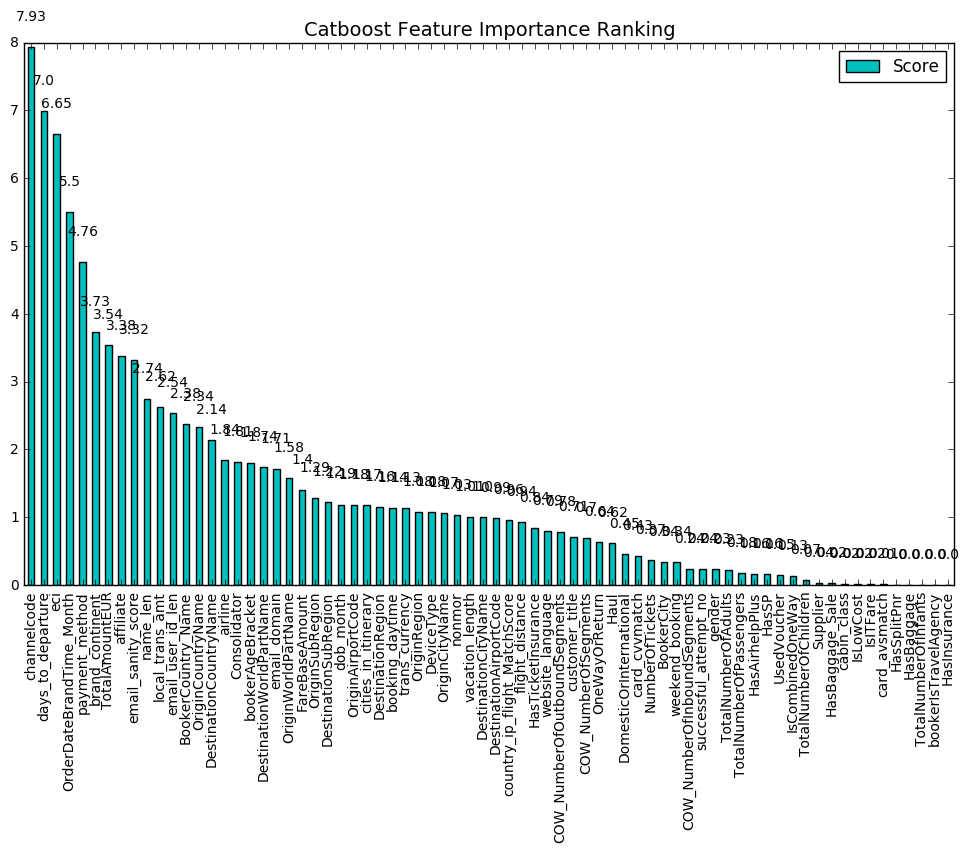

In [33]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
# Export the model JSON
model.save_model("model_json", format = "json", export_parameters=None)

from_file = CatBoostClassifier()
# Load the model from JSON
from_file.load_model("model_json", format = 'json')

# Get ROC curve

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

# Model Comparison

In [ ]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

# Feature importances

In [ ]:
model.get_feature_importance(prettified=True)